In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from tsfresh.examples.robot_execution_failures import download_robot_execution_failures, load_robot_execution_failures
from tsfresh import defaults, extract_features
from tsfresh.feature_selection.feature_selector import check_fs_sig_bh
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import ComprehensiveFCParameters

matplotlib.rcParams["figure.figsize"] = [16, 6]
matplotlib.rcParams["font.size"] = 14
matplotlib.style.use('seaborn-darkgrid')

E:\Windows\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Parameter setting

In [2]:
FDR_LEVEL = defaults.FDR_LEVEL
HYPOTHESES_INDEPENDENT = defaults.HYPOTHESES_INDEPENDENT

## Load robot data

In [3]:
download_robot_execution_failures()
df, y = load_robot_execution_failures()
df.head()

,id,time,a,b,c,d,e,f
0,1,0,-1,-1,63,-3,-1,0
1,1,1,0,0,62,-3,-1,0
2,1,2,-1,-1,61,-3,0,0
3,1,3,-1,-1,63,-2,-1,0
4,1,4,-1,-1,63,-3,-1,0


## Extract Features

In [4]:
X = extract_features(df, 
                     column_id='id', column_sort='time',
                     default_fc_parameters=ComprehensiveFCParameters(),
                     impute_function=impute)

Feature Extraction: 100%|████████████████████████████████████████████████████████████████| 6/6 [00:17<00:00,  2.88s/it]
 'd__spkt_welch_density__coeff_8' 'c__spkt_welch_density__coeff_8'
 'f__spkt_welch_density__coeff_8' 'e__spkt_welch_density__coeff_8'] did not have any finite values. Filling with zeros.


## Calculate p-values and Benjamini-Yekutieli Procedure

### Mann-Whitney-U

In [5]:
df_pvalues_mann = check_fs_sig_bh(X, y, fdr_level=FDR_LEVEL, test_for_binary_target_real_feature='mann')

In [6]:
{
    "# relevant": (df_pvalues_mann["rejected"] == True).sum(),
    "# irrelevant": (df_pvalues_mann["rejected"] == False).sum(),
    "# constant": (df_pvalues_mann["type"] == "const").sum(),
    "# total": len(df_pvalues_mann)
}

{'# constant': 281, '# irrelevant': 1032, '# relevant': 300, '# total': 1332}

In [7]:
df_pvalues_mann.head()

,Feature,rejected,type,p_value
Feature,,,,
a__abs_energy,a__abs_energy,True,real,5.900086e-12
a__range_count__max_1__min_-1,a__range_count__max_1__min_-1,True,real,6.268453e-12
b__abs_energy,b__abs_energy,True,real,6.327674e-12
e__variance,e__variance,True,real,6.778390e-12
e__standard_deviation,e__standard_deviation,True,real,6.778390e-12


### Kolmogorov-Smirnov

In [8]:
df_pvalues_smir = check_fs_sig_bh(X, y, fdr_level=FDR_LEVEL, test_for_binary_target_real_feature='smir')

In [9]:
{
    "# relevant": (df_pvalues_smir["rejected"] == True).sum(),
    "# irrelevant": (df_pvalues_smir["rejected"] == False).sum(),
    "# constant": (df_pvalues_smir["type"] == "const").sum(),
    "# total": len(df_pvalues_smir)
}

{'# constant': 281, '# irrelevant': 699, '# relevant': 633, '# total': 1332}

In [10]:
df_pvalues_smir.head()

,Feature,rejected,type,p_value
Feature,,,,
a__abs_energy,a__abs_energy,True,real,2.343896e-15
b__abs_energy,b__abs_energy,True,real,6.491072e-15
a__standard_deviation,a__standard_deviation,True,real,6.491072e-15
e__standard_deviation,e__standard_deviation,True,real,6.491072e-15
e__variance,e__variance,True,real,6.491072e-15


## Calculate rejection line

### Mann-Whitney-U

In [11]:
m = len(df_pvalues_mann.loc[~(df_pvalues_mann.type == "const")])
K = list(range(1, m + 1))

if HYPOTHESES_INDEPENDENT:
    C = [1] * m
else:
    C = [sum([1.0 / i for i in range(1, k + 1)]) for k in K]

rejection_line_mann = [FDR_LEVEL * k / m * 1.0 / c for k, c in zip(K, C)]

### Kolmogorov-Smirnov

In [12]:
m = len(df_pvalues_smir.loc[~(df_pvalues_smir.type == "const")])
K = list(range(1, m + 1))

if HYPOTHESES_INDEPENDENT:
    C = [1] * m
else:
    C = [sum([1.0 / i for i in range(1, k + 1)]) for k in K]

rejection_line_smir = [FDR_LEVEL * k / m * 1.0 / c for k, c in zip(K, C)]

## Plot ordered p-values and rejection line

### Mann-Whitney-U

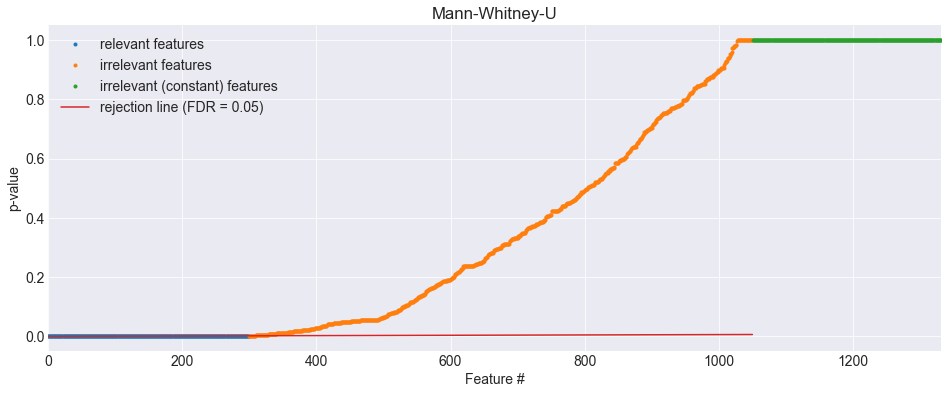

In [13]:
df_pvalues_mann.index = pd.Series(range(0, len(df_pvalues_mann.index)))

df_pvalues_mann.p_value.where(df_pvalues_mann.rejected)\
    .plot(style=".", label="relevant features")

df_pvalues_mann.p_value.where(~df_pvalues_mann.rejected & (df_pvalues_mann.type != "const"))\
    .plot(style=".", label="irrelevant features")

df_pvalues_mann.p_value.fillna(1).where(df_pvalues_mann.type == "const")\
    .plot(style=".", label="irrelevant (constant) features")

plt.plot(rejection_line_mann, label="rejection line (FDR = " + str(FDR_LEVEL) + ")")
plt.xlabel("Feature #")
plt.ylabel("p-value")
plt.title("Mann-Whitney-U")
plt.legend()

### Kolmogorov-Smirnov

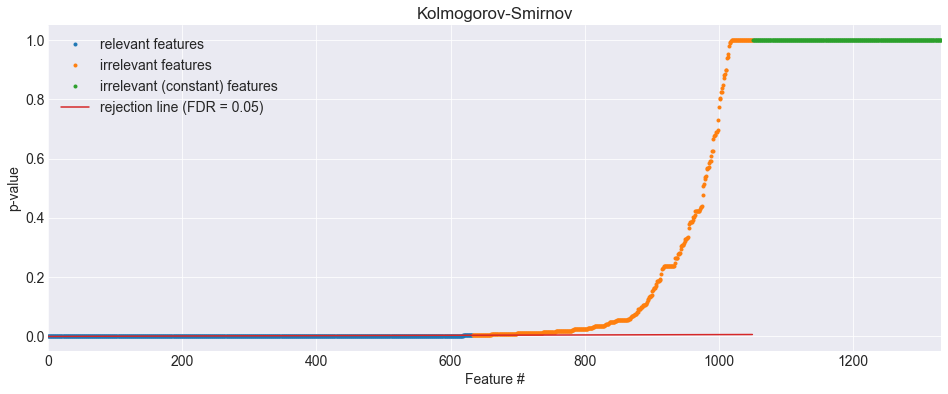

In [14]:
df_pvalues_smir.index = pd.Series(range(0, len(df_pvalues_smir.index)))

df_pvalues_smir.p_value.where(df_pvalues_smir.rejected)\
    .plot(style=".", label="relevant features")

df_pvalues_smir.p_value.where(~df_pvalues_smir.rejected & (df_pvalues_smir.type != "const"))\
    .plot(style=".", label="irrelevant features")

df_pvalues_smir.p_value.fillna(1).where(df_pvalues_smir.type == "const")\
    .plot(style=".", label="irrelevant (constant) features")

plt.plot(rejection_line_smir, label="rejection line (FDR = " + str(FDR_LEVEL) + ")")
plt.xlabel("Feature #")
plt.ylabel("p-value")
plt.title("Kolmogorov-Smirnov")
plt.legend()

## Plot zoomed ordered p-values and rejection line

### Mann-Whitney-U

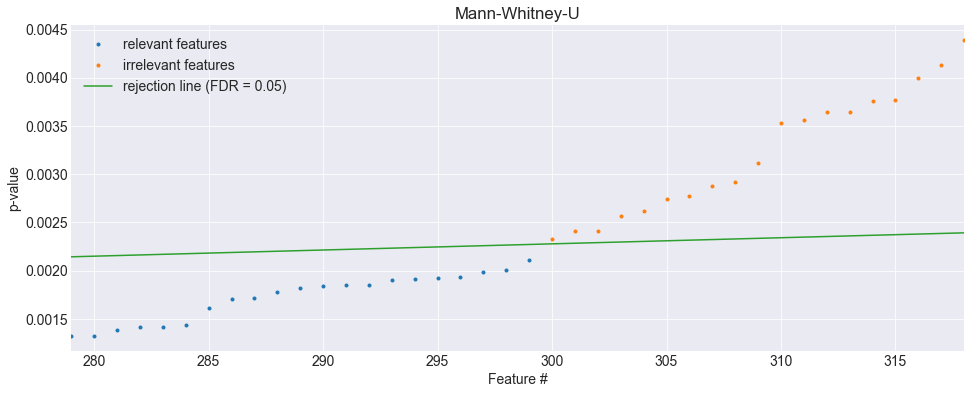

In [15]:
last_rejected_index = (df_pvalues_mann["rejected"] == True).sum() - 1
margin = 20
a = max(last_rejected_index - margin, 0)
b = min(last_rejected_index + margin, len(df_pvalues_mann) - 1)

df_pvalues_mann[a:b].p_value.where(df_pvalues_mann[a:b].rejected)\
    .plot(style=".", label="relevant features")
df_pvalues_mann[a:b].p_value.where(~df_pvalues_mann[a:b].rejected)\
    .plot(style=".", label="irrelevant features")
plt.plot(np.arange(a, b), rejection_line_mann[a:b], label="rejection line (FDR = " + str(FDR_LEVEL) + ")")
plt.xlabel("Feature #")
plt.ylabel("p-value")
plt.title("Mann-Whitney-U")
plt.legend()

### Kolmogorov-Smirnov

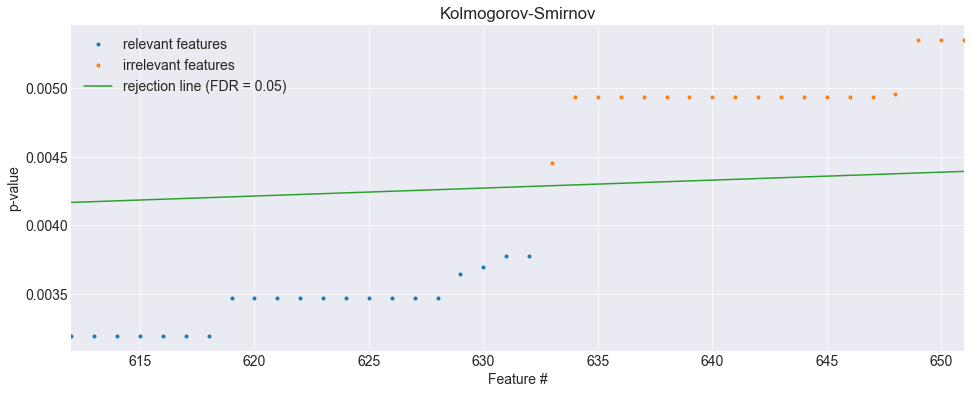

In [16]:
last_rejected_index = (df_pvalues_smir["rejected"] == True).sum() - 1
margin = 20
a = max(last_rejected_index - margin, 0)
b = min(last_rejected_index + margin, len(df_pvalues_smir) - 1)

df_pvalues_smir[a:b].p_value.where(df_pvalues_smir[a:b].rejected)\
    .plot(style=".", label="relevant features")
df_pvalues_smir[a:b].p_value.where(~df_pvalues_smir[a:b].rejected)\
    .plot(style=".", label="irrelevant features")
plt.plot(np.arange(a, b), rejection_line_smir[a:b], label="rejection line (FDR = " + str(FDR_LEVEL) + ")")
plt.xlabel("Feature #")
plt.ylabel("p-value")
plt.title("Kolmogorov-Smirnov")
plt.legend()